In [1]:
import os
import pickle

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from temporal_template import *

# Turn the motion videos into MHIs

In [3]:
def extract_main_features(file_path, n):
    """
    Args:
        file_path (str): relative path of the input video
        n (int): number of returned feature

    Return:
        mhi_series (list): n normalized motion history images
    """
    cap = cv2.VideoCapture(file_path)
    total_frame_num = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
    mhi_series = []
    for t in range(0, total_frame_num-25, 10):
        cap.set(1, t)
        mhi = compute_mhi(cap, tau=15, threshold=50)
        mhi_series.append(mhi)
    mhi_series.sort(key=lambda x:x.sum(), reverse=True)
    return mhi_series[:n]

Below section will turn all 6 categories of videos into MHIs. Each action forms a high-dimentional matric with shape (25, 4, 5, 120, 160) where the value corresponds to (25 people, 4 directions of shooting, select 5 dominant MHIs, each MHI with shape (120, 160)).

For each action, in total of (25 ppl x 4 view angle x 5 major MHIs) = 500 MHIs are generated and saved with naming pattern "{}_MHIs.npy" where the bracket is filled in with action listed in categories, eg. 'running', 'jogging', 'walking', 'handclapping', 'handwaving', and 'boxing'.

In [4]:
categories = ['running', 'jogging', 'walking', 'handclapping', 'handwaving', 'boxing']
feature_num_per_video = 5

for category in categories:
    if os.path.isfile('{}_MHIs.npy'.format(category)):
        print '{}_MHIs.npy already existed.'.format(category)
        continue
    path = '../FinalProjectDataset/{}/'.format(category)
    videoname_list = os.listdir(path)
    videoname_list.sort()

    action_of_everyone = []
    for video_name in videoname_list:
        action_features = extract_main_features(os.path.join(path, video_name), feature_num_per_video)
        action_of_everyone.append(action_features)
    action_of_everyone = np.array(action_of_everyone).reshape(-1, 4, feature_num_per_video, 120, 160)
    print action_of_everyone.shape
    np.save('{}_MHIs'.format(category), action_of_everyone)

running_MHIs.npy already existed.
jogging_MHIs.npy already existed.
walking_MHIs.npy already existed.
handclapping_MHIs.npy already existed.
handwaving_MHIs.npy already existed.
boxing_MHIs.npy already existed.


# Turn MHIs into MEIs

In [5]:
categories = ['running', 'jogging', 'walking', 'handclapping', 'handwaving', 'boxing']
for category in categories:
    if os.path.isfile('{}_MEIs.npy'.format(category)):
        print '{}_MEIs.npy already existed.'.format(category)
        continue
    action_of_everyone = np.load('{}_MHIs.npy'.format(category))
    binary_action_of_everyone = np.zeros(action_of_everyone.shape, dtype=np.uint8)
    for people in range(25):
        for angle in range(4):
            for top5 in range(5):
                binary_action_of_everyone[people, angle, top5] = \
                (action_of_everyone[people, angle, top5] > 0).astype(np.uint8)
    np.save('{}_MEIs'.format(category), binary_action_of_everyone)

running_MEIs.npy already existed.
jogging_MEIs.npy already existed.
walking_MEIs.npy already existed.
handclapping_MEIs.npy already existed.
handwaving_MEIs.npy already existed.
boxing_MEIs.npy already existed.


# Split the data into 3 parts: 
### Train, Val, Test = [8ppl, 8ppl, 9ppl]

In [6]:
subjects = np.arange(25)
np.random.shuffle(subjects)
train, validate, test = subjects[:8], subjects[8:16], subjects[16:]

# Compute the Hu Moments of MHIs
For each action, turn MHI matrix (25, 4, 5, 120, 160) into (25, 4, 5, 7)

In [7]:
categories = ['running', 'jogging', 'walking', 'handclapping', 'handwaving', 'boxing']
MHIs_humoments = []

for category in categories:
    action_of_everyone = np.load('{}_MHIs.npy'.format(category))
    assert action_of_everyone.shape == (25, 4, 5, 120, 160)
    mhi_humoments_of_everyone = np.zeros((25, 4, 5, 7))
    for people in range(25):
        for angle in range(4):
            for top5 in range(5):
                mhi_humoments_of_everyone[people, angle, top5] = \
                cv2.HuMoments(cv2.moments(action_of_everyone[people, angle, top5])).flatten()
    MHIs_humoments.append(mhi_humoments_of_everyone)
np.save('MHI_HuMoments', np.array(MHIs_humoments))

In [8]:
MEIs_humoments = []
for category in categories:
    binary_action_of_everyone = np.load('{}_MEIs.npy'.format(category))
    assert binary_action_of_everyone.shape == (25, 4, 5, 120, 160)
    mei_humoments_of_everyone = np.zeros((25, 4, 5, 7))
    for people in range(25):
        for angle in range(4):
            for top5 in range(5):
                mei_humoments_of_everyone[people, angle, top5] = \
                cv2.HuMoments(cv2.moments(binary_action_of_everyone[people, angle, top5])).flatten()
    MEIs_humoments.append(mei_humoments_of_everyone)
np.save('MEI_HuMoments', np.array(MEIs_humoments))

# Preview of effectiveness of Hu Moments as features

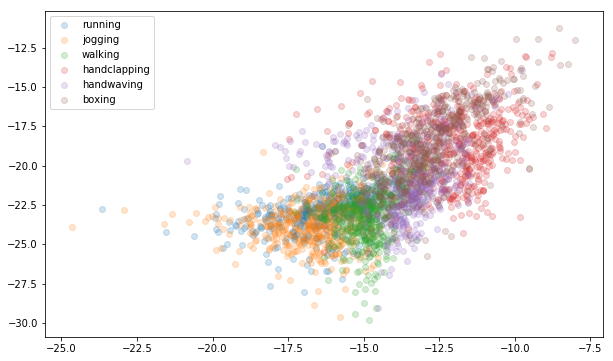

In [107]:
plt.figure(figsize=(10, 6));
for category in range(6):
    x = np.log(np.array(MHIs_humoments)[category, :, :, :, 1])
    y = np.log(np.array(MHIs_humoments)[category, :, :, :, 2])
    plt.scatter(x, y, alpha=0.2, label=categories[category]); plt.legend();
plt.savefig('hu_moments_2d.png')

/Users/huben/anaconda3/envs/scipy/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log


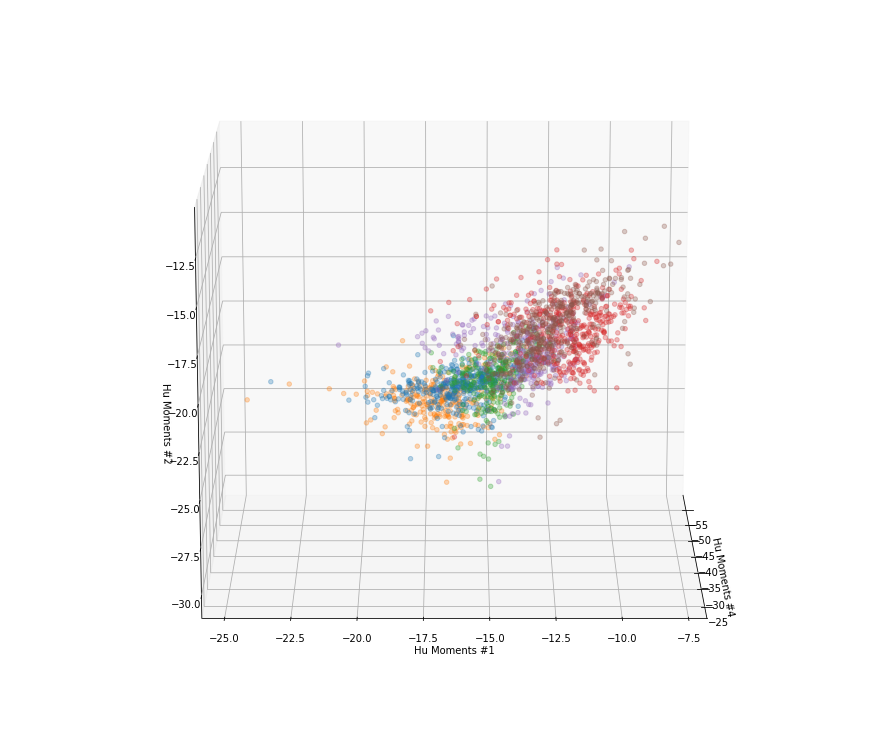

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10));
ax = Axes3D(fig)

for category in range(6):
    x = np.log(np.array(MHIs_humoments)[category, :, :, :, 4])
    y = np.log(np.array(MHIs_humoments)[category, :, :, :, 1])
    z = np.log(np.array(MHIs_humoments)[category, :, :, :, 2])
    ax.scatter(x, y, z, alpha=0.3, label=categories[category]);
    ax.set_xlabel('Hu Moments #4');
    ax.set_ylabel('Hu Moments #1');
    ax.set_zlabel('Hu Moments #2');

for angle in range(0, 360, 360):
    ax.view_init(elev=15, azim=angle);
    # plt.savefig('{}.png'.format(angle))

# Classifier: SVM

In [11]:
from sklearn import datasets, svm, metrics

In [101]:
motion_data = []
for category in categories:
    motion = np.load('{}_MHIs.npy'.format(category))
    motion = motion.reshape(-1, 120, 160)
    motion_data.append(motion)
motion_data = np.vstack(motion_data)
print motion_data.shape

(3000, 120, 160)


In [102]:
n = 5
ppl = 25
labels = np.array([([0+10*i]*n + [1+10*i]*n + [2+10*i]*n + [3+10*i]*n)*ppl for i in range(6)]).flatten()
print labels.shape

(3000,)


In [103]:
label_digits = [10*j + i for j in range(6) for i in range(4)]
label_description = ['{}_d{}'.format(categories[j], i+1) for j in range(6) for i in range(4)]
label_translation = dict(zip(label_digits, label_description))

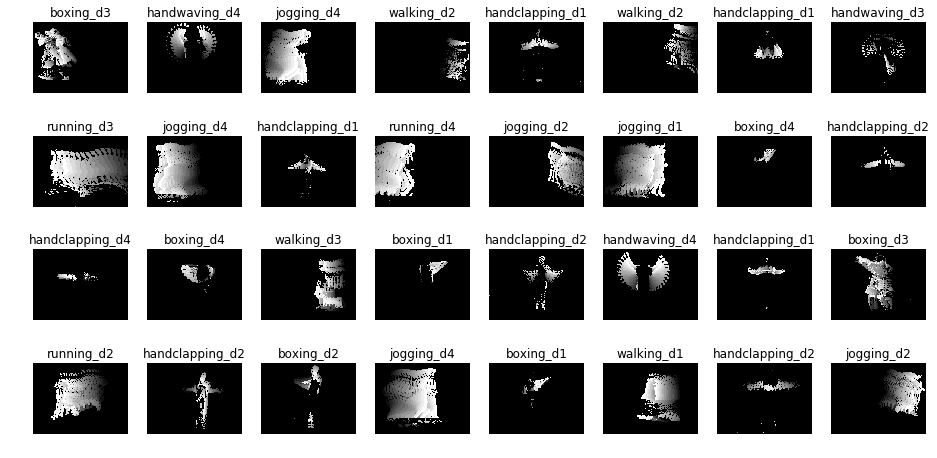

In [106]:
plt.figure(figsize=(16,8));
motions_and_labels = np.array(zip(motion_data, labels))
for index, (image, label) in enumerate(motions_and_labels[np.random.randint(0,3000,size=32)]):
    plt.subplot(4, 8, index + 1);
    plt.axis('off');
    plt.title(label_translation[label]);
    plt.imshow(image, cmap='gray');
#     plt.savefig('mhis.png');

Flat the motion images into a 1-D array

In [16]:
length = motion_data.shape[0]
motion_data_1d = motion_data.reshape(length, -1)
print motion_data_1d.shape

(3000, 19200)


Shuffle the data

In [17]:
shuffle_ind = np.random.choice(range(3000), replace=False, size=3000)
print labels[:50]
labels = labels[shuffle_ind]
print labels[:50]
motion_data_1d = motion_data_1d[shuffle_ind]

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3
 3 3 3 0 0 0 0 0 1 1 1 1 1]
[11 53 33  2 32  3  1 42 51 33 43 32 33 43 13 32 33 53 20 23 12 53 51 40  0
  1 10 53 52 20 41 22 23 42 52  3 22  3 50 52 42 13  1  1  3 40 11 53 23 30]


In [18]:
if os.path.isfile('SVM_general_model.sav'):
    print "model already exists, load in..."
    classifier = pickle.load(open('SVM_general_model.sav', 'rb'))
else:
    print "fitting model..."
    classifier = svm.SVC(C=5, gamma=0.017, kernel='linear', probability=True)
    classifier.fit(motion_data_1d[:2000], labels[:2000])
    pickle.dump(classifier, open('SVM_general_model.sav', 'wb'))

expected = labels[2000:]
predicted = classifier.predict(motion_data_1d[2000:])

print "Accuracy: {0:.3f}".format(sum(expected//10 == predicted//10)/float(len(expected)))
print "Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted)

fitting model...
Accuracy: 0.788
Confusion matrix:
[[18  5 10  3  0  0  2  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3 19  3  0  2  2  0  0  2  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 4  0 30  4  1  1  3  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  2 24  3  0  4  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  3  6 13  2  6  1  3  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0 18  2  0  3  9  0  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 2  4  5  5  8  0 15  5  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  6  2  0  0 23  0  1  0  7  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  2  0  2 15  3  3  6  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  2 20  0  0  0  0  0  1  0  0  0  2  0  0  0  0]
 [ 0  2  0  1  6  1  3  0 14  1 10  1  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  1  0  0  0  1  0  3  5  1  1 27  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 33  1  6  4

In [20]:
zip(expected[expected//10 != predicted//10], predicted[expected//10 != predicted//10])[:10]

[(13, 3),
 (22, 12),
 (51, 31),
 (12, 3),
 (10, 2),
 (52, 22),
 (22, 10),
 (12, 3),
 (12, 3),
 (11, 21)]

### Assume given the shooting direction (angle)
Seperate the training images based on their view angle

In [19]:
n = 5
ppl = 25
labels = np.array([([0+i]*ppl*n + [10+i]*ppl*n + [20+i]*ppl*n + [30+i]*ppl*n + [40+i]*ppl*n + [50+i]*ppl*n) for i in range(4)])
print labels.shape

(4, 750)


In [21]:
motion_data = []
for category in categories:
    motion = np.load('{}_MHIs.npy'.format(category))
    motion_data.append(motion.reshape(25, 4, 5, -1))

motion_data = np.rollaxis(np.array(motion_data), 2)
motion_data = motion_data.reshape(4, -1, 120*160)
print motion_data.shape

(4, 750, 19200)


In [22]:
shuffle_ind = np.random.choice(range(750), replace=False, size=750)
for angle in range(4):
    print labels[angle, :50]
    labels[angle] = labels[angle, shuffle_ind]
    print labels[angle, :50]
    motion_data[angle] = motion_data[angle, shuffle_ind]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[20 20 50 20 30  0  0 10  0 50 10 20 10 30 30 10 40 10  0  0 40 50 50 40 10
  0 50 40 10 30  0 40 10 50 40 40 20 20 10 10 50 20  0 20 50 40 50 20 50 10]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[21 21 51 21 31  1  1 11  1 51 11 21 11 31 31 11 41 11  1  1 41 51 51 41 11
  1 51 41 11 31  1 41 11 51 41 41 21 21 11 11 51 21  1 21 51 41 51 21 51 11]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]
[22 22 52 22 32  2  2 12  2 52 12 22 12 32 32 12 42 12  2  2 42 52 52 42 12
  2 52 42 12 32  2 42 12 52 42 42 22 22 12 12 52 22  2 22 52 42 52 22 52 12]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3]
[23 23 53 23 33  3  3 13  3 53 13 23 13 33 33 13 43 13  3  3 43 53 53 43 13
  3 53 43 13 33  3 43 13 53 43 43 23 23 13 13 53 23  

In [25]:
for view in range(4):
    classifier = svm.SVC(C=5, gamma=0.017, kernel='linear', probability=True)
    classifier.fit(motion_data[view, :375], labels[view, :375])

    expected = labels[view, 375:]
    predicted = classifier.predict(motion_data[view, 375:])
    print "Direction: d{0} Accuracy: {1:.3f}".format(view+1, sum(expected == predicted)/float(len(expected)))
    print "Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted)

Direction: d1 Accuracy: 0.845
Confusion matrix:
[[40 16  1  0  0  0]
 [ 1 43 14  0  0  0]
 [ 0  8 47  0  0  2]
 [ 0  0  1 66  0  3]
 [ 0  0  0  4 60  2]
 [ 0  0  0  6  0 61]]
Direction: d2 Accuracy: 0.731
Confusion matrix:
[[30 18  7  1  1  0]
 [16 25 15  0  0  2]
 [ 1  9 46  0  0  1]
 [ 0  1  1 60  5  3]
 [ 2  3  1  6 52  2]
 [ 0  0  2  4  0 61]]
Direction: d3 Accuracy: 0.789
Confusion matrix:
[[40 10  7  0  0  0]
 [11 31 16  0  0  0]
 [ 0  6 48  1  1  1]
 [ 0  0  0 60  2  8]
 [ 0  0  0  4 60  2]
 [ 0  0  1  5  4 57]]
Direction: d4 Accuracy: 0.864
Confusion matrix:
[[46 11  0  0  0  0]
 [ 5 36 17  0  0  0]
 [ 0  9 48  0  0  0]
 [ 0  0  0 68  0  2]
 [ 0  0  0  0 64  2]
 [ 0  0  2  3  0 62]]


# Use CNN for MHIs classification

In [343]:
from keras import Sequential
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adam, Adagrad
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import LeakyReLU

In [416]:
X = []
for category in categories:
    motion = np.load('{}_MHIs.npy'.format(category))
    motion = motion.reshape(-1, 120, 160, 1)
    X.append(motion)
X = np.vstack(X)
print X.shape

(3000, 120, 160, 1)


In [417]:
n = 5
ppl = 25
Y = np.array([[i]*n*ppl*4 for i in range(6)]).flatten()
Y = to_categorical(Y)
# Y = np.array([([0+10*i]*n + [1+10*i]*n + [2+10*i]*n + [3+10*i]*n)*ppl for i in range(6)]).flatten()
print Y.shape

(3000, 6)


In [418]:
shuffle_ind = np.random.choice(range(3000), replace=False, size=3000)
X_train, X_test = X[shuffle_ind][:1800], X[shuffle_ind][1800:]
Y_train, Y_test = Y[shuffle_ind][:1800], Y[shuffle_ind][1800:]

print X_train.shape
print X_test.shape

(1800, 120, 160, 1)
(1200, 120, 160, 1)


In [419]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(120, 160, 1)))
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.05))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
# model.add(Dropout(0.05))
model.add(Dense(6))
model.add(Activation('softmax'))

In [421]:
learning_rate = 0.001
learning_decay = learning_rate/32

early_stop = EarlyStopping(monitor='val_acc', patience=3)
sgd = SGD(lr=learning_rate, decay=learning_decay, momentum=0.)
adam = Adam(lr=learning_rate, decay=learning_decay)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 120, 160, 16)      160       
_________________________________________________________________
activation_277 (Activation)  (None, 120, 160, 16)      0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 118, 158, 16)      2320      
_________________________________________________________________
activation_278 (Activation)  (None, 118, 158, 16)      0         
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 59, 79, 16)        0         
_________________________________________________________________
flatten_62 (Flatten)         (None, 74576)             0         
_________________________________________________________________
dense_154 (Dense)            (None, 128)               9545856   
__________

In [422]:
batch_size = 128
epoch = 32

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epoch,
          validation_split=0.2,
          shuffle=True,
          callbacks=[early_stop])
model.save('CNN_model.h5')

Train on 1440 samples, validate on 360 samples
Epoch 1/32
1440/1440 [==============================] - 47s 32ms/step - loss: 10.5900 - acc: 0.3104 - val_loss: 10.8471 - val_acc: 0.3250
Epoch 2/32
1440/1440 [==============================] - 39s 27ms/step - loss: 10.8630 - acc: 0.3243 - val_loss: 10.9696 - val_acc: 0.3194
Epoch 3/32
1440/1440 [==============================] - 39s 27ms/step - loss: 10.5262 - acc: 0.3451 - val_loss: 11.0493 - val_acc: 0.3139
Epoch 4/32
1440/1440 [==============================] - 38s 27ms/step - loss: 10.6170 - acc: 0.3403 - val_loss: 11.6705 - val_acc: 0.2722


# Test on real video

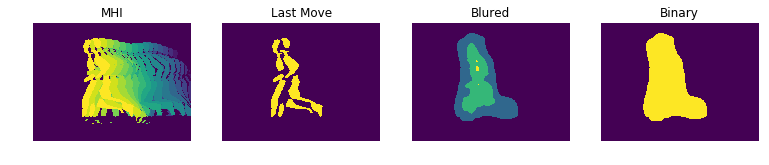

In [121]:
plt.figure(figsize=(13, 10));
img = motion_data_1d[2090].reshape(120, 160)
plt.subplot(141); plt.imshow(img); plt.axis('off'); plt.title('MHI');
plt.subplot(142); plt.imshow(img == img.max()); plt.axis('off'); plt.title('Last Move');

kernel = np.ones((20, 20))/100
dst = cv2.filter2D((img == img.max()).astype(np.uint8), -1, kernel)
plt.subplot(143); plt.imshow(dst); plt.axis('off'); plt.title('Blured');

loc = ((dst != 0) * 255).astype(np.uint8)
plt.subplot(144); plt.imshow(loc); plt.axis('off'); plt.title('Binary');
plt.savefig('detection_window.png');

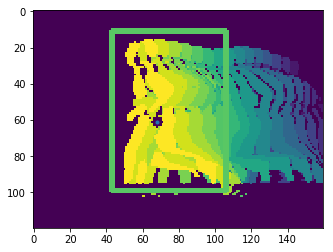

In [123]:
M = cv2.moments(loc)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

boundX = [i for i, val in enumerate(loc.argmax(axis=1)) if val]
boundY = [i for i, val in enumerate(loc.argmax(axis=0)) if val]
topX, bottomX = boundX[0], boundX[-1]
topY, bottomY = boundY[0], boundY[-1]

cv2.rectangle(img, (topY, topX), (bottomY, bottomX), 190, 2)
cv2.circle(img, (cX, cY), 0, 0, 5)
plt.plot(cX, cY, '.')
plt.imshow(img)
plt.savefig('draw_box.png')

In [535]:
loc.argmax(axis=0)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 45, 43, 41, 38, 35,
       33, 32, 30, 29, 27, 25, 24, 23, 22, 21, 20, 20, 18, 17, 16, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 16, 17, 19, 21, 22, 23, 24, 26, 28,
       30, 35, 38,  0,  0,  0,  0])

In [591]:
def draw_contoure(mhi, dst_image):
    """
    """
    if mhi.sum() < 1000:
        return dst_image
    # find the latest motion
    src = (mhi == mhi.max()).astype(np.uint8)
    # blur the image with weighting
    kernel = np.ones((20, 20))/10
    blured = cv2.filter2D(src, -1, kernel)
    # binary the blured image to find contoure
    binary = ((blured != 0) * 255).astype(np.uint8)

    # the center
    M = cv2.moments(binary)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    # rectangle coordinate
    boundX = [i for i, val in enumerate(binary.argmax(axis=0)) if val]
    boundY = [i for i, val in enumerate(binary.argmax(axis=1)) if val]
    topX, bottomX = boundX[0], boundX[-1]
    topY, bottomY = boundY[0], boundY[-1]

    # draw on dst_image
    image = dst_image.copy()
    cv2.rectangle(image, (topX, topY), (bottomX, bottomY), 255, 1)
    cv2.circle(image, (cX, cY), 0, 255, 3)
    return image

In [592]:
i = draw_contoure(np.zeros(img.shape), img)

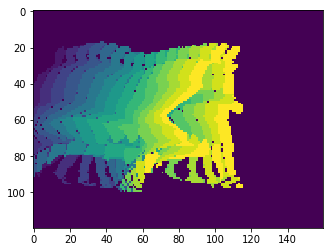

In [593]:
plt.imshow(i)

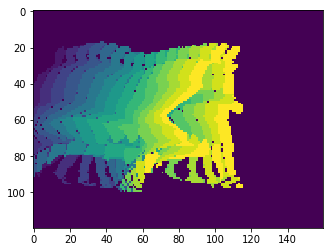

In [590]:
plt.imshow(img)

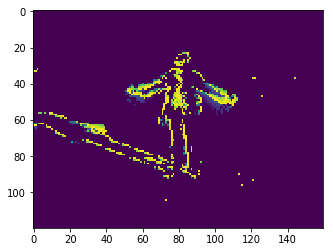

In [72]:
img = motion_data_1d[np.random.choice(3000)]
plt.imshow(img.reshape(120, 160))

In [74]:
classifier.predict_proba([img])

array([[ 0.00819284,  0.01152602,  0.04183733,  0.56229757,  0.028686  ,
         0.34746024]])

In [78]:
def mhi_matching(clf, mhi):
    """
    """
    assert mhi.shape == (160, 120), "wrong size of input MHI"
    motion_probs = clf.predict_proba([mhi.reshape(-1,),])[0]
    most_likeli_ind = motion_probs.argmax()
    return most_likeli_ind, motion_probs[most_likeli_ind]

In [79]:
mhi_matching(classifier, img.reshape(160, 120))

(3, 0.56229757125371482)

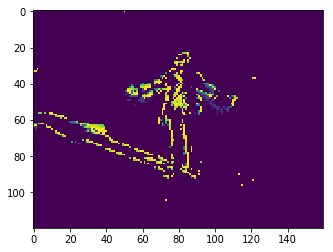

In [99]:
i = img.reshape(120, 160)
cv2.putText(i, 'ABCD\nfjsdf', (100, 50), cv2.FONT_HERSHEY_COMPLEX, 12, 0, 1)
plt.imshow(i)